In [1]:
import numpy as np
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt 
import matplotlib as mlp
import scipy.optimize as optimize
import pandas as pd
from copy import copy

import matplotlib.patches as mpatches 

%load_ext autoreload
%autoreload 2
# You can load your python module as this:
import Functions2021 as fun

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$
c_t = w h_t l_t\;\;\text{if}\;\;l_t=1
$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$
c_t = b\;\;\text{if}\;\;l_t=0
$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ 
\frac{c_t^{1-\rho}}{1-\rho} 
$$

Her **disutility of working** is:

$$ 
\gamma l_t 
$$

From period 1 to period 2, she **accumulates human capital** according to:

$$ 
\begin{aligned}
h_2 &= h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases}
\end{aligned}
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{aligned}
v_{2}(h_{2}) & = \max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = \begin{cases}
w h_2 & 
\text{if }l_2 = 1  \\
b & \text{if }l_2 = 0 
\end{cases} \\
l_{2}& \in \{0,1\}
\end{aligned}
$$

In the **first period** the worker thus solves:

$$
\begin{aligned}
v_{1}(h_{1}) &= \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right] \\ \text{s.t.} \\
c_{1}& = \begin{cases}
w h_1 & 
\text{if }l_1 = 1  \\
b & \text{if }l_1 = 0 
\end{cases} \\
h_2 &= h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in \{0,1\}\\
\end{aligned}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100)

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

In [4]:
x_format= lambda x,pos : f'{x:.2f}'
formatter= [MultipleLocator(0.2),x_format,MultipleLocator(0.2),x_format]

In [5]:
def u(c,rho):
    '''
    Utility_function
    Args:
        c (float)  : Amount consumed
        rho (float): Parameter
    
    returns:
        Utility of worker gained from comsumption
    
    '''
    if rho==1:
        return np.log(c)
    else:
        return c**(1-rho)/(1-rho)

def v2(c2,l2,gamma,rho):
    '''
    Total utility in period 2
    Args:
        c2 (float)   : Amount consumed in period 2
        l2 (int)     : Whether the worker works or not, in period 2
                       can either be 0 or 1. 
        gamma,rho (float): parameters
        
    Returns:
        v2 (float)   : Net utility in period 2. 
        
    '''
    v2 = u(c2,rho)-gamma*l2
    return v2

def eq_constraint(c2,w,h2,l2):
    return c2-w*h2*l2


In [6]:
def solve_period_2(h2_vec,b,rho,gamma,return_full=False):
    '''
    Solves the optimization problem for period two,
    e.g compares utility of the two possible scenarios,
    and chooses the highest utility.
    
    Args:
        h2_vec (array)      : Human capital of the worker
        b (float)           : Unemployment benefit if she decides not to work
        rho,gamma (floats)  : Parameters
        output_utility(bool): If True returns utility if False returns l2
        
    Returns:
        Utility (float) : Net utility in period 2
        l2 (int)        : Either 0 or 1, if 0 she decides not to work, if 1 she does work.
    
    '''
    shape = h2_vec.shape
    b_vec = np.full(shape,b,dtype=float)
    
    u_work = v2(w*h2_vec,1,gamma,rho)
    u_nowork = v2(b_vec,0,gamma,rho)
    u_vec = np.fmax(u_work,u_nowork)
    
    if return_full:
        l2_vec = np.array((u_work>u_nowork),dtype=int)
        return u_vec, l2_vec, u_work, u_nowork
        
    return u_vec

In [7]:
u2_vec, l2_vec, u2_work, u2_nowork = solve_period_2(h_vec,b,rho,gamma,return_full=True)

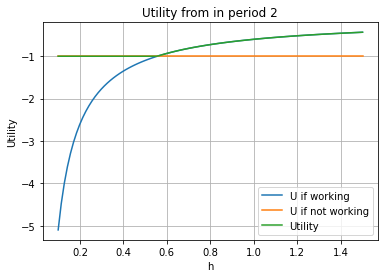

In [8]:
fig, ax = fun.plot('h',['U if working','U if not working','Utility'],h_vec,[u2_work,u2_nowork,u2_vec],'Utility',title ='Utility from in period 2')

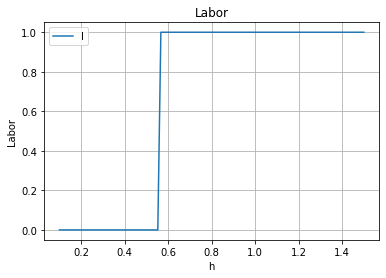

In [9]:
fig, ax = fun.plot('h',['l'],h_vec,[l2_vec],'Labor',title='Labor')

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 


In [10]:
from scipy import interpolate

In [11]:
def v1(c1,l1, h1 ,v2_interp, b,w,rho,beta,gamma,Delta):
    '''
    Calculates the expected utility from period 1
    
    Args:
        l1 (int)   : Either 0 (for not working) or 1 (for working)
        h1 (float) : Inital amount of human capital
        b (float)  : Unemployment benefits
        w (float)  : Standard wage rate (income is calculated as the products between this and human capital)
        rho,beta,gamma (floats) : Parameters
        Delta (float) : Stochatic increase in human capital (with probability 0.5)
        
    Returns:
        Utility (float): Expected utility in period 1
    
    '''
    
    # utility expected in period 2 is calculated as the mean of the two possible outcomes of increase in human capital:
    h2 = h1 + l1
    u2_good = v2_interp(h2+Delta)[0]
    u2_bad = v2_interp(h2+Delta)[0]
    expected_u2 = (u2_good+u2_bad)/2
    
    
    utility = u(c1,rho)-gamma*l1+beta*expected_u2
    return utility

In [12]:
def solve_period1(h1_vec,v2_interp,b,w,rho,beta,gamma,Delta,return_full=False):
    '''
    Solves the utility maximization problem in period 1, by comparing the two options
    of the worker, and choosing the highest utility.
    
    Args:
        Args:
        h1_vec (array) : Inital amount of human capital
        b (float)  : Unemployment benefits
        w (float)  : Standard wage rate (income is calculated as the products between this and human capital)
        rho,beta,gamma (floats) : Parameters
        Delta (float) : Stochatic increase in human capital (with probability 0.5)
        output_utility(bool): If True returns utility if False returns l1
    
    Returns:
        Utility (float) : Net utility in period 2
        l1 (int)        : Either 0 or 1, if 0 she decides not to work, if 1 she does work.
        
    '''
    shape = h1_vec.shape
    
    b_vec = np.full(shape,b,dtype=float)
    
    u_work = v1(w*h1_vec,1,h1_vec,v2_interp, b,w,rho,beta,gamma,Delta)
    u_nowork = v1(b_vec,0,h1_vec,v2_interp, b,w,rho,beta,gamma,Delta)
    u_vec = np.fmax(u_work,u_nowork)
    
    if return_full:
        l1_vec = np.array((u_work>u_nowork),dtype=int)
        return u_vec, l1_vec, u_work, u_nowork
        
    return u_vec

In [13]:
v2_interp = interpolate.RegularGridInterpolator((h_vec,), u2_vec,
                                                bounds_error=False,fill_value=None)


In [14]:
u1_vec, l1_vec, u1_work, u1_nowork = solve_period1(h_vec,v2_interp,b,w,rho,beta,gamma,Delta,return_full=True)

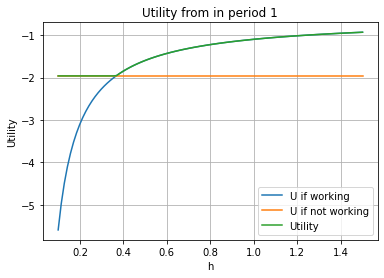

In [15]:
fig, ax = fun.plot('h',['U if working','U if not working','Utility'],h_vec,[u1_work,u1_nowork,u1_vec],'Utility',title ='Utility from in period 1')

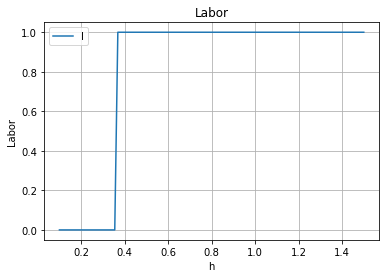

In [16]:
fig, ax = fun.plot('h',['l'],h_vec,[l1_vec],'Labor',title='Labor')

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

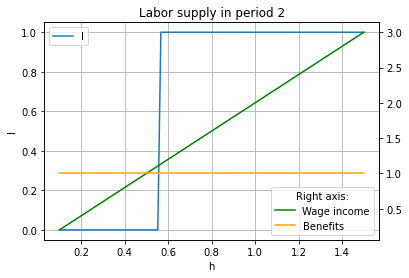

In [17]:
fig, ax = fun.plot('h',['l'],h_vec,[l2_vec],'l',title='Labor supply in period 2')
# twin object for two different y-axis on the sample plot

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
w_vec = w*h_vec
b_vec = b_vec = np.full(h_vec.shape,b,dtype=float)
ax2.plot(h_vec,w_vec,color='green',label='Wage income')
ax2.plot(h_vec,b_vec,color='orange',label='Benefits')
ax2.legend(loc=4,title='Right axis:');

In period 2, it is clear that the worker will only work if wage are sufficiently higher than benifits to outweight the disutlity from working

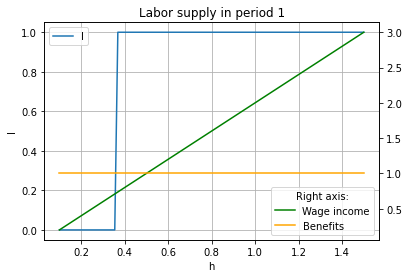

In [18]:
fig, ax = fun.plot('h',['l'],h_vec,[l1_vec],'l',title='Labor supply in period 1')
# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
w_vec = w*h_vec
b_vec = b_vec = np.full(h_vec.shape,b,dtype=float)
ax2.plot(h_vec,w_vec,color='green',label='Wage income')
ax2.plot(h_vec,b_vec,color='orange',label='Benefits')
ax2.legend(loc=4,title='Right axis:');

For period 1, the workers starts working before wages are higher than benefits. This is because working increases the workers' human capital, increasing wage income in period 2. 

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ 
y_{t} = -\alpha r_{t} + v_{t} 
$$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ 
i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}
$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$
r_{t} = i_{t} - \pi_{t+1}^{e}
$$

Together, the above implies that the **AD-curve** is

$$
\pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]
$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$
\pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}
$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$
\pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}
$$

Together, this implies that the **SRAS-curve** can also be written as

$$
\pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1}
$$

The **parameters** of the model are:

In [19]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

In [20]:
import sympy as sm

In [21]:
#Initiate variables
pi_t = sm.symbols('\pi_{t}')
h = sm.symbols('h')
alpha = sm.symbols('\\alpha')
v_t = sm.symbols('v_{t}')
b = sm.symbols('b')
y_t = sm.symbols('y_{t}')
y_t1 = sm.symbols('y_{t-1}')
pi_t1 = sm.symbols('\pi_{t-1}')
gamma = sm.symbols('\gamma')
phi = sm.symbols('phi')
s_t = sm.symbols('s_t')
s_t1 = sm.symbols('s_{t-1}')

In [22]:
ad = sm.Eq(pi_t,1/(h*alpha)*(v_t-(1+b*alpha)*y_t))
ad

Eq(\pi_{t}, (v_{t} - y_{t}*(\alpha*b + 1))/(\alpha*h))

In [23]:
sras =sm.Eq(pi_t,pi_t1+gamma*y_t-phi*gamma*y_t1+s_t-phi*s_t1)
sras

Eq(\pi_{t}, -\gamma*phi*y_{t-1} + \gamma*y_{t} + \pi_{t-1} - phi*s_{t-1} + s_t)

In [24]:
# Set pi_ad = pi_sras
pi_from_ad = ad.rhs
equilibrium_y = sras.subs(pi_t,pi_from_ad)
equilibrium_y

Eq((v_{t} - y_{t}*(\alpha*b + 1))/(\alpha*h), -\gamma*phi*y_{t-1} + \gamma*y_{t} + \pi_{t-1} - phi*s_{t-1} + s_t)

And solve for $y$ and $\pi$ : 

In [25]:
y_eq = sm.solve(equilibrium_y,y_t)[0]
y_equation = sm.Eq(y_t,y_eq)
# define as python function:
_y_equilibrium = sm.lambdify((y_t1,pi_t1,v_t,s_t,s_t1,alpha,gamma,h,b,phi),y_eq)

# print our solution symbolicaly 
y_equation

Eq(y_{t}, (\alpha*\gamma*h*phi*y_{t-1} - \alpha*\pi_{t-1}*h + \alpha*h*phi*s_{t-1} - \alpha*h*s_t + v_{t})/(\alpha*\gamma*h + \alpha*b + 1))

In [26]:
equilibrium_pi_equation = ad.subs(y_t,y_eq)
pi_equation = sm.Eq(pi_t,sm.solve(equilibrium_pi_equation,pi_t)[0])
# define as python function:
_pi_equilibrium = sm.lambdify((y_t1,pi_t1,v_t,s_t,s_t1,alpha,gamma,h,b,phi),sm.solve(equilibrium_pi_equation,pi_t)[0])
# print our solution symbolicaly 
pi_equation

Eq(\pi_{t}, (-\alpha*\gamma*b*phi*y_{t-1} + \alpha*\pi_{t-1}*b - \alpha*b*phi*s_{t-1} + \alpha*b*s_t - \gamma*phi*y_{t-1} + \gamma*v_{t} + \pi_{t-1} - phi*s_{t-1} + s_t)/(\alpha*\gamma*h + \alpha*b + 1))

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

In [27]:
# Create dictionary for substuting in 0
vars_0 = {}
for var in [y_t1,pi_t1,v_t,s_t,s_t1]:
    vars_0[var]=0
    
y_equation.subs(vars_0)

Eq(y_{t}, 0)

In [28]:
pi_equation.subs(vars_0)

Eq(\pi_{t}, 0)

In [29]:
# Now for v_t =0.1:
vars_0[v_t]=0.1
y_v1 = y_equation.subs(vars_0)
y_v1

Eq(y_{t}, 0.1/(\alpha*\gamma*h + \alpha*b + 1))

In [30]:
pi_v1 = pi_equation.subs(vars_0)
pi_v1

Eq(\pi_{t}, 0.1*\gamma/(\alpha*\gamma*h + \alpha*b + 1))

In [31]:
# Count numerical answer from analytical solution:
paras = {}
for var, value in zip([alpha,gamma,h,b],[par['alpha'],par['gamma'],par['h'],par['b']]):
    paras[var]=value
y_v1.subs(paras)

Eq(y_{t}, 0.0244140625)

In [32]:
pi_v1.subs(paras)

Eq(\pi_{t}, 0.0018310546875)

In [33]:
# Redifine function ot take in shocks and par
y_equilibrium = fun.redefine_fun(_y_equilibrium)

# No shock should be zero
assert y_equilibrium(0,0,0,0,0,par)==0

# with shock is correct
y_equilibrium(0,0,0.1,0,0,par)

0.0244140625

In [34]:
y_equilibrium

<function Functions2021.redefine_fun.<locals>.<lambda>(y_t1, pi_t1, v_t, s_t, s_t1, par)>

In [35]:
pi_equilibrium = fun.redefine_fun(_pi_equilibrium)


# No shock should be zero
assert pi_equilibrium(0,0,0,0,0,par)==0
# with shock is correct
pi_equilibrium(0,0,0.1,0,0,par)

0.0018310546875

In [36]:
y_gaps = np.linspace(-0.01,0.03,100)

#We find the ad-and sras curves: 
# period 0:
ad = fun.ad(y_gaps,0,par)
sras = fun.sras(y_gaps,0,0,0,0,par)
# period 1:
ad1 = fun.ad(y_gaps,0.1,par)

''

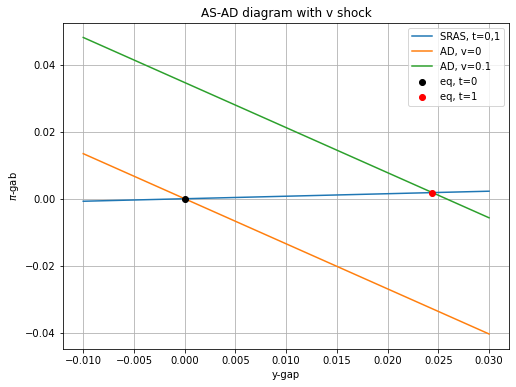

In [37]:
fig, ax = fun.plot('y-gap',['SRAS,t=0,1','AD, v=0','AD, v=0.1'],y_gaps,[sras, ad, ad1],'$\pi$-gab',title='AS-AD diagram with v shock',figsize=(8,6))
ax.scatter(0,0,label='Equilibrium',color='black',zorder=10)
ax.scatter(y_equilibrium(0,0,0.1,0,0,par),pi_equilibrium(0,0,0.1,0,0,par),label='Equilibrium',color='red',zorder=10)
ax.legend(['SRAS, t=0,1','AD, v=0','AD, v=0.1','eq, t=0','eq, t=1'])
;

In [38]:
## Extra, interactive:

from ipywidgets import interact
import ipywidgets as widgets

In [39]:
# we find equilibrium path
T = 100
pis = [0,pi_equilibrium(0,0,0.1,0,0,par)]
ys = [0,y_equilibrium(0,0,0.1,0,0,par)]

for i in range(1,T):
    # Caluclate lagged variables
    ys.append(y_equilibrium(ys[-1],pis[-1],0,0,0,par))
    pis.append(pi_equilibrium(ys[-1],pis[-1],0,0,0,par))

In [40]:
#  Calculate curves at each point in time
ad_curve = fun.ad(y_gaps,0,par)
ad_curves = [ad_curve for i in range(T+1)]
ad_curves[1] = fun.ad(y_gaps,0.1,par)

sras_curves = [fun.sras(y_gaps,0,0,0,0,par)]

for i in range(T+1):
    sras_curves.append(fun.sras(y_gaps,ys[i],pis[i],0,0,par))

In [41]:
def interactive_figure(t,title,data):
    # Unpack
    sras_curves, ad_curves, ys, pis,y_gaps = data
    
    # Calculate SRAS in period t:
    
    sras_t = sras_curves[t]
    ad_t   = ad_curves[t]
    
    fig, ax = fun.plot('y-gap',['SRAS,t=0,1','AD, v=0','AD, v=0.1'],y_gaps,[sras_curves[0], ad_curves[0], ad_curves[1]],'$\pi$-gab',title=title,figsize=(10,8))
    ax.scatter(ys[0],pis[0],label='Equilibrium',color='black',zorder=10)
    ax.scatter(ys[1],pis[1],label='Equilibrium',color='purple',zorder=10)
    
    ax.plot(y_gaps,sras_t,color='darkblue',linestyle='--',zorder=11)
    ax.plot(y_gaps,ad_t,color='darkgreen',linestyle='--',zorder=11)
    
    ax.scatter(ys[t],pis[t],color='red',zorder=12)
    
    ax.legend(['SRAS, t=0,1','AD, v=0','AD, v=0.1',f'SRAS, t={t}',f'AD, t={t}','eq, t=0','eq, t=1',f'eq t={t}']);


In [42]:
interact(interactive_figure, t=widgets.IntSlider(min=1,max=50,step=1,value=1,layout=widgets.Layout(width='30%')),
        title=widgets.fixed('AS-AD diagram with v shock in period 1, zero otherwise'),
        data = widgets.fixed([sras_curves, ad_curves, ys, pis,y_gaps]));

interactive(children=(IntSlider(value=1, description='t', layout=Layout(width='30%'), max=50, min=1), Output()…

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ 
\begin{aligned}
v_{t} &= \delta v_{t-1} + x_{t} \\
s_{t} &= \omega s_{t-1} + c_{t} 
\end{aligned}
$$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [43]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

First we look at period 0 and 1 

In [44]:
v0 = fun.d_pers(0,0.1,par)
y0 = y_equilibrium(0,0,v0,0,0,par)
pi0 = pi_equilibrium(0,0,v0,0,0,par)
print(f'Outputgab in period 0 is    {y0:.4f}')
print(f'Inflationgab in period 0 is {pi0:.4f}')

Outputgab in period 0 is    0.0244
Inflationgab in period 0 is 0.0018


In [45]:
v1 = fun.d_pers(v0,0,par)
y1 = y_equilibrium(y0,pi0,v1,0,0,par)
pi1 = pi_equilibrium(y0,pi0,v1,0,0,par)
print(f'Outputgab in period 1 is    {y1:.4f}')
print(f'Inflationgab in period 1 is {pi1:.4f}')

Outputgab in period 1 is    0.0182
Inflationgab in period 1 is 0.0032


In [46]:
T = 100
vs = [0,v0]
ys2 = [0,y0]
pis2= [0,pi0]

for i in range(1,T):
    vs.append(fun.d_pers(vs[i],0,par))
    ys2.append(y_equilibrium(ys2[i],pis2[i],vs[i+1],0,0,par))
    pis2.append(pi_equilibrium(ys2[i],pis2[i],vs[i+1],0,0,par))
    
zeros = [0 for i in range(0,T+1)]

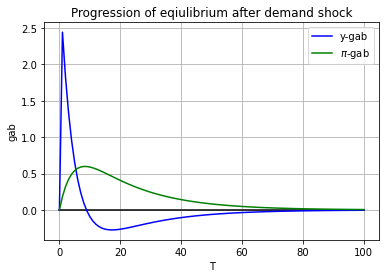

In [47]:
fig, ax = fun.plot('T',['','y-gab','$\pi$-gab'],range(0,T+1),[zeros,[y*100 for y in ys2],[pi*100 for pi in pis2]],'gab',
                   y_colors = ['black','blue','green'],title='Progression of eqiulibrium after demand shock')

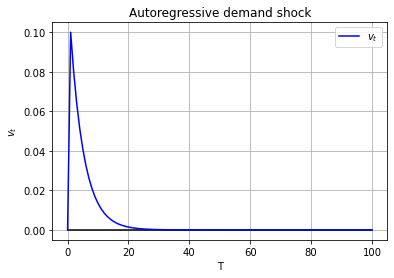

In [48]:
fig, ax = fun.plot('T',['','$v_{t}$'],range(0,T+1),[zeros,vs],'$v_{t}$',
                   y_colors = ['black','blue'],title='Autoregressive demand shock')

Now the entire AD-AS plot

In [49]:
y_gaps2 = np.linspace(-0.02,0.05,100)


#  Calculate curves at each point in time
ad_curves2 = [fun.ad(y_gaps2,v,par) for v in vs]
sras_curves2 = [fun.sras(y_gaps2,0,0,0,0,par)]
for i in range(T+1):
    sras_curves2.append(fun.sras(y_gaps2,ys2[i],pis2[i],0,0,par))

In [50]:
interact(interactive_figure, t=widgets.IntSlider(min=1,max=T,step=1,value=1,layout=widgets.Layout(width='30%')),
        title=widgets.fixed('AS-AD diagram with Autoregressive demand shock in period 1'),
        data = widgets.fixed([sras_curves2, ad_curves2, ys2, pis2, y_gaps2]));

interactive(children=(IntSlider(value=1, description='t', layout=Layout(width='30%'), min=1), Output()), _dom_…

With a autoregressive shock, the adaptive $\pi$-expectations are consistently exceeded, leading to a rising $\pi$-gap until around period 8, the high $\pi$-expectations causes a negative y-gap as the economy re-converges

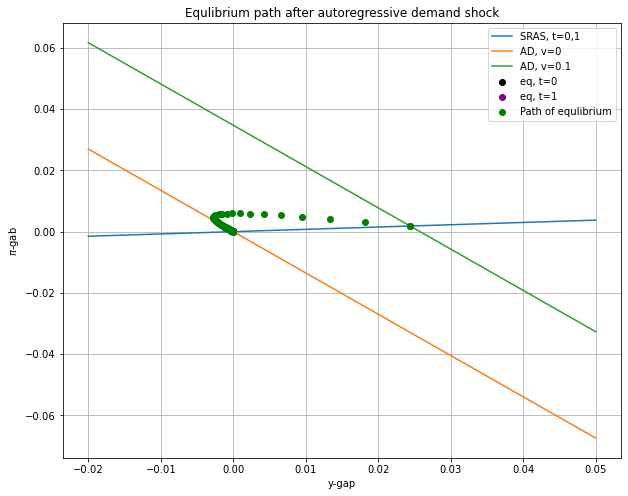

In [51]:
# Static plot also
fig, ax = fun.plot('y-gap',['SRAS,t=0,1','AD, v=0','AD, v=0.1'],y_gaps2,[sras_curves2[0], ad_curves2[0], ad_curves2[1]],
                   '$\pi$-gab',title='Equlibrium path after autoregressive demand shock',figsize=(10,8))
ax.scatter(ys2[0],pis2[0],label='Equilibrium',color='black',zorder=10)
ax.scatter(ys2[1],pis2[1],label='Equilibrium',color='purple',zorder=10)
    
ax.scatter(ys2,pis2,color='green',zorder=12)
    
ax.legend(['SRAS, t=0,1','AD, v=0','AD, v=0.1','eq, t=0','eq, t=1',f'Path of equlibrium']);

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ 
\begin{aligned}
x_{t}&\sim\mathcal{N}(0,\sigma_{x}^{2}) \\
c_{t}&\sim\mathcal{N}(0,\sigma_{c}^{2}) \\
\end{aligned}
$$

The **standard deviations of the shocks** are:

In [52]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

In [53]:
## We set it up as a function because we need it later also: 

def sim_asad(par,t=1000,seed= 1986):
    '''
    Simulates the AS-AD model, with persistence stochastic chocks
    
    Args:
        par (dict)  : Dictionairy of parameter values
        t (int)     : Amount of periods simulated
    
    Returns:
        correlations (list): containing:
                                    Variance of outputgab
                                    Variance of inflationgab
                                    Correlations between output and inflation
                                    Autocorrelation of output 1 period back
                                    Autocorrelation of inflation 1 period back
        
        ys (list)   : The simulated outputgabs
        pis (list)  : The simulated inflation gbs
        vs (list)   : The simulated demand chocks
        ss (list)   : The simulated supply chocks
    
    '''
    
    np.random.seed(seed)

    # Draw random data:
    xs = np.random.normal(0,par['sigma_x'],t)
    cs = np.random.normal(0,par['sigma_c'],t)
    
    # Calculate chocks in first period
    vs = [fun.d_pers(0,xs[0],par)]
    ss = [fun.s_pers(0,cs[0],par)]
    
    #Calculate equilibrium in first period
    ys = [y_equilibrium(0,0,vs[0],ss[0],0,par)]
    pis = [pi_equilibrium(0,0,vs[0],ss[0],0,par)]
    
    
    # Calculate chocks and equlibrium in every subsequent period:
    for i in range(1,t):
        vs.append(fun.d_pers(vs[i-1],xs[i],par))
        ss.append(fun.s_pers(ss[i-1],cs[i],par))
        ys.append(y_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
        pis.append(pi_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
    
    correlations = [np.var(ys),np.var(pis),np.corrcoef(ys,pis)[0,1],
             np.corrcoef(ys[:-1],ys[1:])[0,1],
             np.corrcoef(pis[:-1],pis[1:])[0,1]]
    
    return correlations,ys,pis, vs, ss
    
t= 1000

In [54]:
correlations,ys_sim,pis_sim, vs,ss = sim_asad(par)

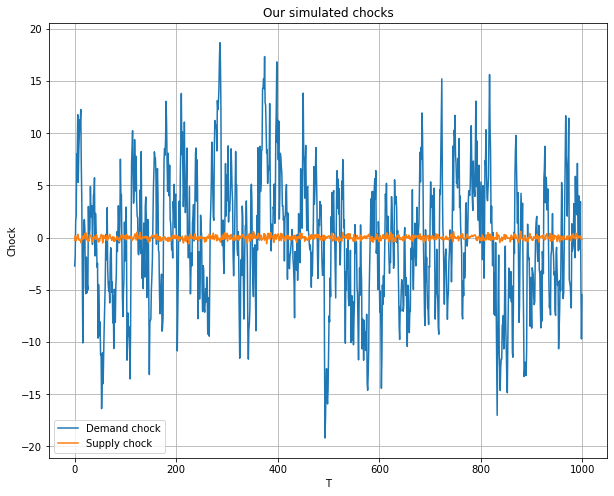

In [55]:
fig, ax = fun.plot('T',['Demand chock','Supply chock'],range(t),[vs,ss],
                   'Chock',legendlocation=3,
                   title='Our simulated chocks',figsize=(10,8))

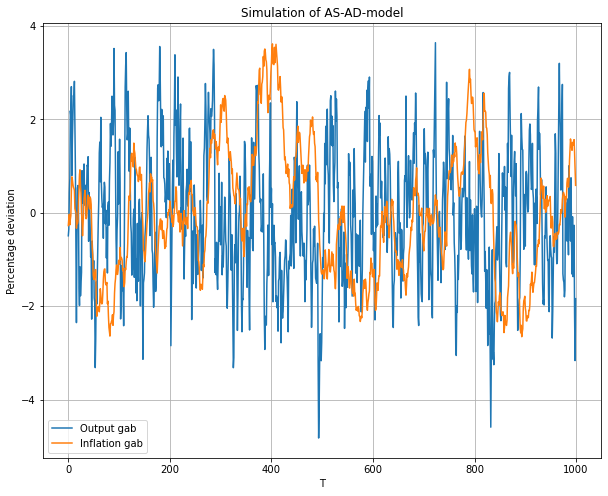

In [56]:

fig, ax = fun.plot('T',['Output gab','Inflation gab'],range(t),[ys_sim,pis_sim],
                   'Percentage deviation',legendlocation=3,
                   title='Simulation of AS-AD-model',figsize=(10,8))

In [57]:
# Make table of correlations
data = [correlations]
df = pd.DataFrame(data, columns = [r'Var(\(y\))',r'Var(\(\pi\))',
                r'Corr(\(\pi,y\))',r'Corr(\(y_{t},y_{t-1}\))',r'Corr (\(\pi_{t},\pi_{t-1}\))    .'],index=['Value'])
df

,Var(\(y\)),Var(\(\pi\)),"Corr(\(\pi,y\))","Corr(\(y_{t},y_{t-1}\))","Corr (\(\pi_{t},\pi_{t-1}\)) ."
Value,1.995473,1.794619,-0.152624,0.780791,0.986923


**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

In [58]:
# Before this we save our original parametervalues
org_par = [par['phi'],par['sigma_x'],par['sigma_c']]

In [59]:
def corr_y_pi(par,vs=vs,ss=ss):
    t = len(vs)
    
    #Calculate first period equilibrium
    ys = [y_equilibrium(0,0,vs[0],ss[0],0,par)]
    pis = [pi_equilibrium(0,0,vs[0],ss[0],0,par)]

    # Calculate equilibrium in subsequent periods 
    for i in range(1,t):
        ys.append(y_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
        pis.append(pi_equilibrium(ys[i-1],pis[i-1],vs[i],ss[i],ss[i-1],par))
    
    return np.corrcoef(ys,pis)[0,1]

In [60]:
corrs =[]
precision = 250 # This is computionaly costly, os it's nice to have a scale so you can test that the code works for a small precision
phis = np.linspace(0,1,precision)
for phi in phis:
    par['phi']=phi
    corrs.append(corr_y_pi(par))

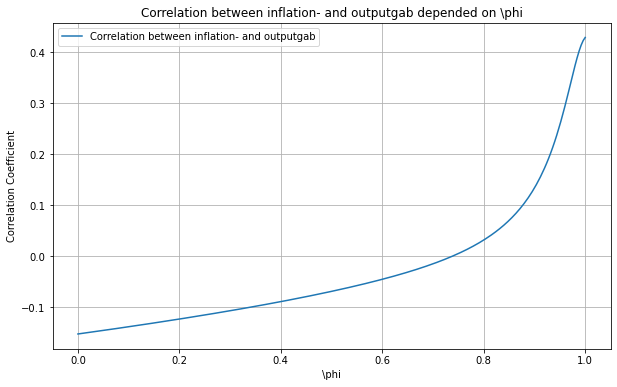

In [61]:
fig, ax = fun.plot('\phi',['Correlation between inflation- and outputgab'],phis,[corrs],
                   'Correlation Coefficient',
                   title='Correlation between inflation- and outputgab depended on \phi',figsize=(10,6))

**Now to find the $\phi$ that makes corr($\pi,y$)=0.31:**

In [62]:
# Objective function:
def obj1(phi,par=par):
    par['phi']=phi
    return corr_y_pi(par)-0.31

res = optimize.root_scalar(obj1,method='bisect',bracket=[0,1])
phi_optimized = res.root

In [63]:
print('The phi that causes the correlation between the output- and inflationgab to be equal to 0.31 is:')
print(f'Phi = {phi_optimized}')

The phi that causes the correlation between the output- and inflationgab to be equal to 0.31 is:
Phi = 0.9640651869867725


In the solution guide, there is an advanced section where it is noted that the above result is dependent on the seed-number, and in order to avoid this, the time period has to be increased. <br>
Since this was a one-week exam and yours will only be 48 hours, I don't think you should worry about those kind of things unless explicitely asked

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

In [64]:
def obj2(paras,par=par,t=1000000):
    par['phi']=paras[0]
    par['sigma_x']=paras[1]
    par['sigma_c']=paras[2]
    
    corrs, ys, pis, vs, ss = sim_asad(par)
    roots = np.array(corrs) -np.array([1.64,0.21,0.31,0.84,0.48])
    return roots

In [65]:
res = optimize.root(obj2,[0.96,par['sigma_x'],par['sigma_c']],method='lm')
diff = res.fun
print(f'As close to zero as we can get with this optimizer: \n{diff}')
print(f'The values found was: \nPhi = {res.x[0]:.4f}, Sigma_x = {res.x[1]:.4f}, Sigma_c = {res.x[2]:.4f}')

As close to zero as we can get with this optimizer: 
[ 0.00524204 -0.15399737 -0.02923762 -0.02311971  0.00360194]
The values found was: 
Phi = 0.9679, Sigma_x = 2.9329, Sigma_c = 0.1880


In [66]:
res

   cov_x: array([[ 0.01174089,  0.00422618, -0.00904721],
       [ 0.00422618,  0.80583566,  0.0097741 ],
       [-0.00904721,  0.0097741 ,  0.14275907]])
    fjac: array([[ 9.47521522e+00,  9.41312757e-02, -3.81220490e-01,
         1.33899043e-03,  9.19585192e-01],
       [ 6.04386089e-01, -2.64775955e+00, -8.53146666e-01,
        -2.12373487e-02, -4.96882992e-01],
       [-5.70232077e-02,  3.21150742e-02, -1.11397837e+00,
        -2.02746571e-04, -9.02179817e-01]])
     fun: array([ 0.00524204, -0.15399737, -0.02923762, -0.02311971,  0.00360194])
    ipvt: array([1, 3, 2], dtype=int32)
 message: 'Both actual and predicted relative reductions in the sum of squares\n  are at most 0.000000'
    nfev: 25
     qtf: array([-3.14058720e-06, -4.76491283e-06, -1.71968721e-07])
  status: 1
 success: True
       x: array([0.96785834, 2.93285097, 0.18796228])

In [67]:
par['phi']=res.x[0]
par['sigma_x']=res.x[1]
par['sigma_c']=res.x[2]
corrs, ys, pis, vs, ss = sim_asad(par)

In [68]:
correlations_list = correlations
corrs_list = corrs
for i in range(3):
    correlations_list.append(org_par[i])
    corrs_list.append(res.x[i])

In [69]:
# phi = 0.972, sigma_x = 3.728, sigma_c = 0.216


In [70]:
data = [correlations_list,corrs_list,[1.64,0.21,0.31,0.84,0.48],list(diff)]
df = pd.DataFrame(data, columns = [r'Var(\(y\))',r'Var(\(\pi\))',
                r'Corr(\(\pi,y\))',r'Corr(\(y_{t},y_{t-1}\))',r'Corr (\(\pi_{t},\pi_{t-1}\))    .',
                r'\(\phi\)',r'\(\sigma_{x}\)',r'\(\sigma_{c}\)'],
                  index=['Original values','Imitated values','US-values','Difference'])

pd.set_option('display.max_colwidth',None)
df

,Var(\(y\)),Var(\(\pi\)),"Corr(\(\pi,y\))","Corr(\(y_{t},y_{t-1}\))","Corr (\(\pi_{t},\pi_{t-1}\)) .",\(\phi\),\(\sigma_{x}\),\(\sigma_{c}\)
Original values,1.995473,1.794619,-0.152624,0.780791,0.986923,0.000000,3.492000,0.200000
Imitated values,1.645242,0.056003,0.280762,0.816880,0.483602,0.967858,2.932851,0.187962
US-values,1.640000,0.210000,0.310000,0.840000,0.480000,NaN,NaN,NaN
Difference,0.005242,-0.153997,-0.029238,-0.023120,0.003602,NaN,NaN,NaN


Again, in the solution guide, there is an advanced section where it is noted that the above result is dependent on the seed-number, and in order to avoid this, the time period has to be increased. <br>
I wouldn't worry to much about it if you don't have time to check those kind of things. <br>
Writting a note, showing that you're aware of these kinds of issues would be good though, You could also note that the answer could be susceptible to having different initial guesses. 

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by $j \in \{1,2,\dots,N\}$
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ 
    \begin{aligned}
    u^{j}(x_{1},x_{2},x_{3}) &=
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     \beta_{i}^{j} &= \frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     \boldsymbol{\alpha}^{j} &= (\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     \log(\boldsymbol{\alpha}^j) &\sim \mathcal{N}(\mu,\Sigma) \\
    \end{aligned} 
    $$

4. Endowments are exponentially distributed,

$$
\begin{aligned}
\boldsymbol{e}^{j} &= (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{aligned}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{aligned}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) &= \beta^{j}_i\frac{I^j}{p_{i}} \\
\end{aligned}
$$

where consumer $j$'s income is

$$
I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j
$$

The **parameters** and **random preferences and endowments** are given by:

In [71]:
## These were given in the assignment: 

# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

In [72]:
betas[:,0].min()

0.1163450663266428

**Question 1:** Plot the histograms of the budget shares for each good across agents.


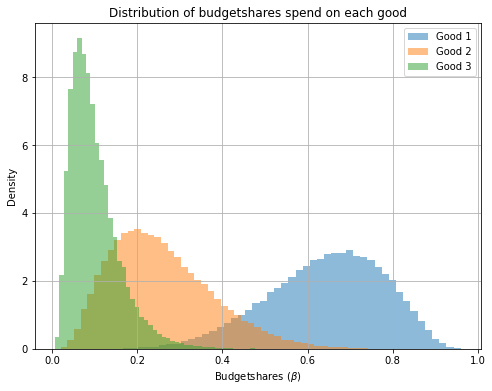

In [73]:
fig,ax = fun.plot_hist(betas.T,names=['Good 1','Good 2','Good 3'],x_label=r'Budgetshares ($\beta$)',title='Distribution of budgetshares spend on each good')


Consider the **excess demand functions:**

$$ 
z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j
$$

**Question 2:** Plot the excess demand functions.

In [74]:
def I(p,es):
    return p@es

def demand(p,es,betas):
    return (betas.T*I(p,es)).T/p

In [75]:
# Testing the demand function
p = np.array([1,1,1])
es = np.array([1,1,2])
betas_test = np.array([0.5,0.25,0.25])

demand(p,es,betas_test)

array([2., 1., 1.])

In [76]:
es = np.array([e1,e2,e3])

In [77]:
demand(p,es,betas)

array([[0.76661134, 0.44309146, 0.23388705],
       [1.67366369, 1.36953188, 0.24707862],
       [5.18651293, 0.48071012, 0.55779709],
       ...,
       [2.48465417, 0.85886191, 0.55548499],
       [1.57676677, 0.24170398, 0.1977252 ],
       [3.41249185, 1.28731181, 0.50591508]])

In [78]:
np.sum(es,axis=1)

array([49923.58458369, 49715.89298445, 50222.97470733])

In [79]:
es

array([[0.23137866, 1.00470578, 2.20634744, ..., 0.45321453, 1.45044167,
        1.24299497],
       [0.23707059, 0.02625265, 0.62545683, ..., 1.52387075, 0.24524643,
        1.57110786],
       [0.97514061, 2.25931576, 3.39321586, ..., 1.92191578, 0.32050786,
        2.39161591]])

In [80]:
def excess_demand(p,es,betas):
    total_demand = np.sum(demand(p,es,betas),axis=0)
    supply = np.sum(es,axis=1)
    
    return total_demand-supply
    

In [81]:
excess_demand(p,es,betas)

array([ 46303.06210182, -11017.95327569, -35285.10882613])

In [82]:
p = np.array([4,1.5,1])
excess_demand(p,es,betas)

array([  2189.3999568 ,   6095.71779981, -17901.17652692])

In [83]:
excess_demand(p,es,betas)

array([  2189.3999568 ,   6095.71779981, -17901.17652692])

**Advanced:** use njit to make it faster

In [84]:
%load_ext line_profiler

In [85]:
def demand_loop(n):
    for i in range(n):
        demands = excess_demand(p,es,betas)

In [86]:
%lprun -f excess_demand -f demand_loop demand_loop(1000)

Timer unit: 1e-07 s

Total time: 2.95416 s
File: <ipython-input-80-0d72d24f8a2f>
Function: excess_demand at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def excess_demand(p,es,betas):
     2      1000   27922171.0  27922.2     94.5      total_demand = np.sum(demand(p,es,betas),axis=0)
     3      1000    1590291.0   1590.3      5.4      supply = np.sum(es,axis=1)
     4                                               
     5      1000      29112.0     29.1      0.1      return total_demand-supply

Total time: 2.95895 s
File: <ipython-input-85-abcbc67e913c>
Function: demand_loop at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def demand_loop(n):
     2      1001       6352.0      6.3      0.0      for i in range(n):
     3      1000   29583170.0  29583.2    100.0          demands = excess_demand(p,es,betas)

In [87]:
def demand_loop_njit(n):
    for i in range(n):
        demands = fun.excess_demand(p,es,betas)
        
demand_loop_njit(1)

In [88]:
%lprun -f fun.excess_demand -f demand_loop_njit demand_loop_njit(1000)

Timer unit: 1e-07 s

Total time: 1.57493 s
File: <ipython-input-87-ec19bf5f9d7a>
Function: demand_loop_njit at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def demand_loop_njit(n):
     2      1001      11706.0     11.7      0.1      for i in range(n):
     3      1000   15737618.0  15737.6     99.9          demands = fun.excess_demand(p,es,betas)

Total time: 0 s
File: C:\Users\Asker\OneDrive - Københavns Universitet\Documents\Arbejde\Undervisning\INPA2\Github\exercises-2021\Exam_2019\Functions2021.py
Function: excess_demand at line 355

Line #      Hits         Time  Per Hit   % Time  Line Contents
   355                                           @njit
   356                                           def excess_demand(p,es,betas):
   357                                               total_demand = np.sum(demand(p,es,betas),axis=0)
   358                                               supply = np.sum(es,axis=1)


In [89]:
def prep_excess_d_plot(p1_bounds,p2_bounds,es,betas, precision=50):
    '''
    Prepares surface plot of excess demand   
    
    Args:
        p1_bounds (tuple)            : upper and lower bound of p1 range
        p2_bounds (tuple)            : upper and lower bound of p2 range
        e (array)                    : Endowments for agents in the model
        betas (array)                : Budget shares spend on each good for agents in the model
        precision (int)              : Precision for the plotted grid 
        
    Returns
        p1s (array)                  : Price of good 1 grid
        p2s (array)                  : Price of good 2 grid
        excess_demands (array)       : grid for calculated excess demand
    
    
    '''
    # Setting p3 numeria 
    p3 = 1
    
    # Initating gridspace
    p1_space = np.linspace(p1_bounds[0],p1_bounds[1],precision)
    p2_space = np.linspace(p2_bounds[0],p2_bounds[1],precision)
    p1s,p2s = np.meshgrid(p1_space,p2_space,indexing='ij')
    
    excess_demands = [np.empty((precision,precision)),np.empty((precision,precision)),np.empty((precision,precision))]
    
    # Calculate excess demand in all instances
    for i in range(precision):
        for j in range(precision):
            p = np.array([p1s[i,j],p2s[i,j],p3])
            excess_demands_i = fun.excess_demand(p,es,betas)
            for k in range(3):
                excess_demands[k][i,j] = excess_demands_i[k]
                
    return p1s,p2s,excess_demands

In [90]:
p1s,p2s,excess_demands= fun.prep_excess_d_plot((3,7),(0.7,5),es,betas)

In [91]:
%matplotlib inline

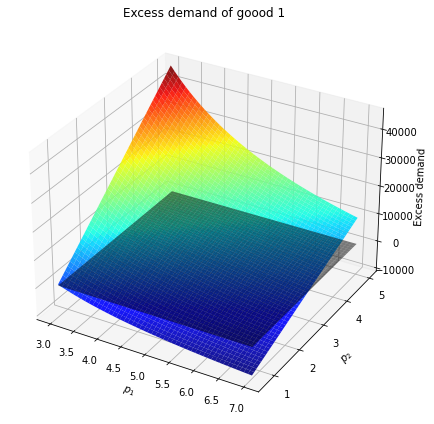

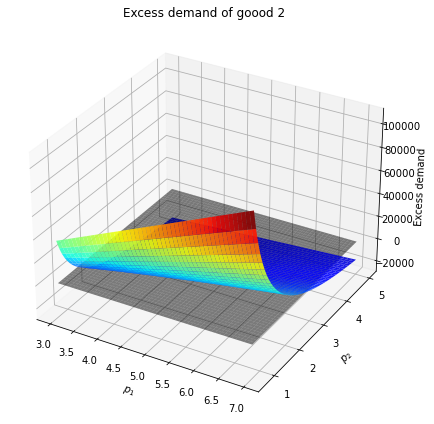

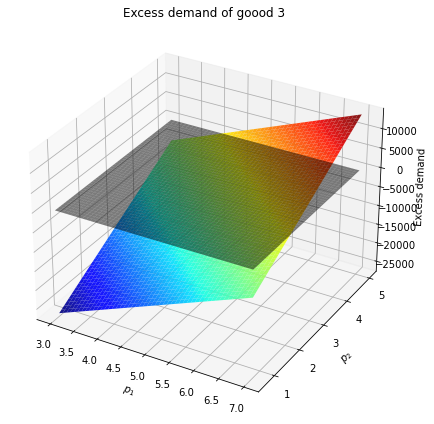

In [92]:
for i in range(3):
    fig,ax = fun.plot_3d(p1s,p2s, excess_demands[i],title=f'Excess demand of goood {i+1}')


In [93]:
%matplotlib widget
for i in range(3):
    fig,ax = fun.plot_3d(p1s,p2s, excess_demands[i],title=f'Excess demand of goood {i+1}',figsize=(6,4))
#ax.invert_xaxis()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [94]:
## All 3 goods in one plot

fig,ax = fun.plot_3d(p1s,p2s, excess_demands[0],title=f'Excess demand of goood ')
fig,ax = fun.plot_3d(p1s,p2s, excess_demands[1],title=f'Excess demand of goood 1 and 2',fig=fig,ax=ax)
fig,ax = fun.plot_3d(p1s,p2s, excess_demands[2],title=f'Excess demand of goood 1, 2 and 3',fig=fig,ax=ax)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [95]:
%matplotlib inline

**Question 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [96]:
def find_equilibrium(p_guess, es, betas, kappa=0.5, eps=0.0001, maxiter=5000):
    '''
    Finds the Walras eqilibrium prices, which clears the markets for good 1 and 2, 
    implictly also clearing the market for good 3 
    
    Args:
        p1,p2,p3 (floats)     : Prices the consumers are faced with
        e1s,e2s,e3s (arrays)  : Endowments of all consumers for each good
        betas (array)         : Shares of budget that the consumers wishes to spend on each good
        kappa (float)         : Aggressivity parameter
        epsilon (float)       : Tolerance
        maxiter (int)         : Maximum number of iterations to calculate
        
    Returns:
        p1,p2 (floats)        : Walras eqiulibrium prices
    
    '''
    
    p = p_guess
    # number of agents in the economy
    N = es.shape[1]
    
    
    t = 0
    while True: 
        Z = fun.excess_demand(p,es,betas)
        
        
        if (np.abs(Z[0]) < eps and np.abs(Z[0])<eps) or t >= maxiter:
            print('\nConverged!!')
            print(f'Step {t:3d}:')
            print(f'p1 = {p[0]:12.8f} -> excess demand 1 -> {Z[0]:14.8f}')
            print(f'p2 = {p[1]:12.8f} -> excess demand 2 -> {Z[1]:14.8f}')
            print(f'Also --------------> excess demand 3 -> {Z[2]:14.8f}')
            break

        p[0] = p[0] + kappa*Z[0]/N
        p[1] = p[1] + kappa*Z[1]/N  
                              
        if (t < 5) or (t%250 == 0) :
            print(f'Step {t:3d}:')      
            print(f'p1 = {p[0]:12.8f} -> excess demand 1-> {Z[0]:14.8f}')
            print(f'p2 = {p[1]:12.8f} -> excess demand 2-> {Z[1]:14.8f}')
                   
        elif t == 5:
            print("  ...")
        t += 1
    return p


In [97]:
p_eq = find_equilibrium(np.array([1.,1.,1.]), es, betas)

Step   0:
p1 =   1.46303062 -> excess demand 1-> 46303.06210182
p2 =   0.88982047 -> excess demand 2-> -11017.95327569
Step   1:
p1 =   1.69901858 -> excess demand 1-> 23598.79584333
p2 =   0.87861970 -> excess demand 2-> -1120.07647568
Step   2:
p1 =   1.87534844 -> excess demand 1-> 17632.98643749
p2 =   0.90653744 -> excess demand 2->  2791.77377238
Step   3:
p1 =   2.02308109 -> excess demand 1-> 14773.26450213
p2 =   0.94726569 -> excess demand 2->  4072.82521031
Step   4:
p1 =   2.15342888 -> excess demand 1-> 13034.77884165
p2 =   0.99045332 -> excess demand 2->  4318.76230716
  ...
Step 250:
p1 =   6.24876665 -> excess demand 1->   230.96616032
p2 =   2.52666268 -> excess demand 2->    86.19665229
Step 500:
p1 =   6.46649102 -> excess demand 1->    21.78973575
p2 =   2.60790307 -> excess demand 2->     8.12911612
Step 750:
p1 =   6.48768317 -> excess demand 1->     2.18614136
p2 =   2.61580911 -> excess demand 2->     0.81555968
Step 1000:
p1 =   6.48981568 -> excess demand 1->

In [98]:
# Now we plot the solution on top of surface plots of excesss demands
p1s,p2s,excess_demands= fun.prep_excess_d_plot((6,7),(2,3),es,betas)

In [99]:
%matplotlib widget

fig,ax = fun.plot_3d(p1s,p2s, excess_demands[0],title=f'Excess demand of goood', cmap=None,alpha=0.8,color='green',figsize=(8,6))
fig,ax = fun.plot_3d(p1s,p2s, excess_demands[1],title=f'Excess demand of goood 1 and 2', cmap=None,alpha=0.8,color='blue',fig=fig,ax=ax)
fig,ax = fun.plot_3d(p1s,p2s, excess_demands[2],title=f'Excess demand of goood 1, 2 and 3', cmap=None,alpha=0.8,color='purple',fig=fig,ax=ax)

p1_vec= [p_eq[0] for i in range(20000)]
p2_vec = [p_eq[1] for i in range(20000)]
z = np.linspace(-2500,12000,20000)
ax.plot(p1_vec,p2_vec,z,color='red',linewidth=3)

labels = [mpatches.Patch(color='green',label='Good 1')]
labels.append(mpatches.Patch(color='blue',label='Good 2'))
labels.append(mpatches.Patch(color='purple',label='Good 3'))
labels.append(mpatches.Patch(color='red',label='Walras equilibrium prices'))

ax.legend(handles=labels,loc='upper left',prop={'size':7})


#Set initial view:
ax.view_init(elev=10, azim=-30)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [100]:
%matplotlib inline

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [101]:
# Demand in equilibrium most be equal to consumption:
xs = demand(p_eq,es,betas)


def utility(xs,betas, gamma):

    utility = (np.prod(xs**betas,axis=1))**gamma
    return utility

u_vec = utility(xs, betas,gamma)

Maximum utility: 4.9756039406231825


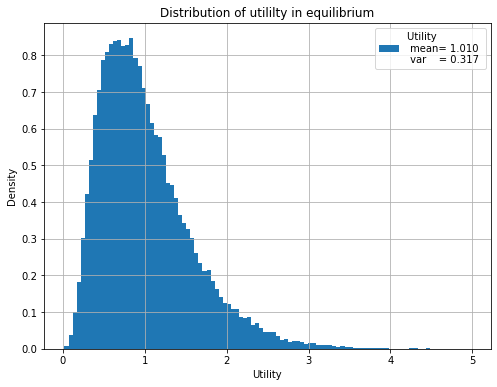

In [102]:
mean, var = np.mean(u_vec), np.var(u_vec)
fig,ax = fun.plot_hist([u_vec],names=[f'Utility \n mean= {mean:1.3f} \n var    = {var:1.3f}'],
                       x_label=r'Utility',bins=100,alpha=1,
                       title='Distribution of utililty in equilibrium')

print(f'Maximum utility: {u_vec.max()}')

We can see that the distriubtion is right skewed with a mean close to 1, indicating that the average comsumer is not much better off, given random distribution of endowments and free trade oportunities, than if all endowments was distributed equally and no trade was allowed, so all consumers consumed precisly one of each good, giving a utility of one independent of parameter-preferences. 

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [103]:
es_means = np.mean(es,axis=1)
es_means

array([0.99847169, 0.99431786, 1.00445949])

In [104]:
# Fill array with equalized endowments
es_equal = np.array([np.full(50000,es_mean) for es_mean in es_means])

In [105]:
es_equal.shape

(3, 50000)

In [106]:
es.shape

(3, 50000)

In [107]:
# Find new optimal prices

p_equal = find_equilibrium(np.array([1.,1.,1.]), es_equal, betas)

Step   0:
p1 =   1.46330453 -> excess demand 1-> 46330.45322635
p2 =   0.88963227 -> excess demand 2-> -11036.77294230
Step   1:
p1 =   1.69929292 -> excess demand 1-> 23598.83904826
p2 =   0.87843458 -> excess demand 2-> -1119.76885211
Step   2:
p1 =   1.87560343 -> excess demand 1-> 17631.05086423
p2 =   0.90641143 -> excess demand 2->  2797.68466085
Step   3:
p1 =   2.02331599 -> excess demand 1-> 14771.25631076
p2 =   0.94720375 -> excess demand 2->  4079.23228785
Step   4:
p1 =   2.15364489 -> excess demand 1-> 13032.89004383
p2 =   0.99044855 -> excess demand 2->  4324.47955791
  ...
Step 250:
p1 =   6.24571933 -> excess demand 1->   230.29963495
p2 =   2.52746983 -> excess demand 2->    86.06653456
Step 500:
p1 =   6.46260238 -> excess demand 1->    21.65877878
p2 =   2.60850812 -> excess demand 2->     8.09143727
Step 750:
p1 =   6.48364458 -> excess demand 1->     2.16581075
p2 =   2.61636909 -> excess demand 2->     0.80909314
Step 1000:
p1 =   6.48575496 -> excess demand 1->

In [108]:
# Comparing with previous prices: 
print(f'Baseline  : {p_eq}')
print(f'New prices: {p_equal}')

Baseline  : [6.49005504 2.61669396 1.        ]
New prices: [6.48599095 2.61724563 1.        ]


In [109]:
# They are surprisingly similar

Maximum utility: 1.6822017567397431


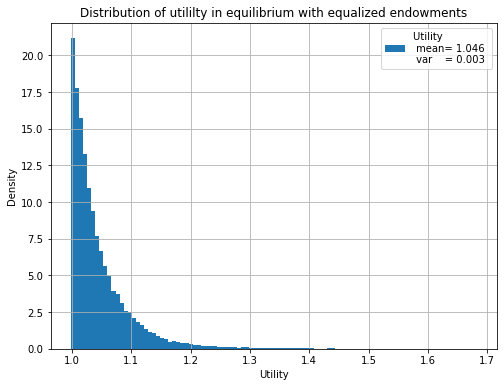

In [110]:
xs_equal = demand(p_equal,es_equal,betas)
u_vec_equal = utility(xs_equal, betas,gamma)
mean_equal, var_equal = np.mean(u_vec_equal), np.var(u_vec_equal)
fig,ax = fun.plot_hist([u_vec_equal],names=[f'Utility \n mean= {mean_equal:1.3f} \n var    = {var_equal:1.3f}'],
                       x_label=r'Utility',bins=100,alpha=1,
                       title='Distribution of utililty in equilibrium with equalized endowments')
print(f'Maximum utility: {u_vec_equal.max()}')

We have a sligthly bigger mean, and a much lower variance, with the endowemnts having been distributed equally. <br>
With everyone starting out with one of each good, all comsumers have a minimum utility of 1. Maximum utility has fallen from 5 to 1.68

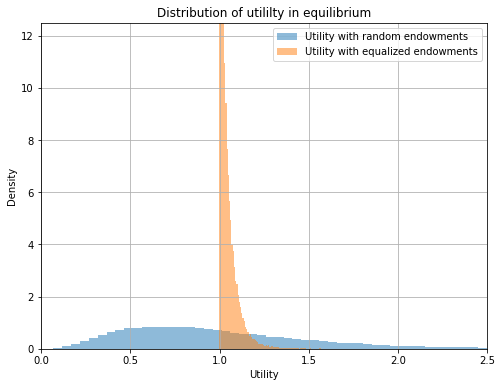

In [111]:
fig,ax = fun.plot_hist([u_vec,u_vec_equal],names=['Utility with random endowments','Utility with equalized endowments'],
                       x_label=r'Utility',bins=100,
                       title='Distribution of utililty in equilibrium')
ax.set_xlim(left=0,right=2.5)
ax.set_ylim(top=12.5);

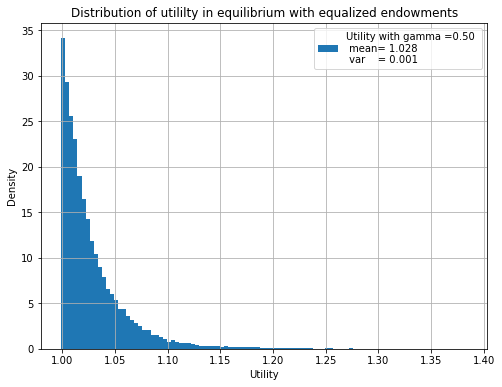

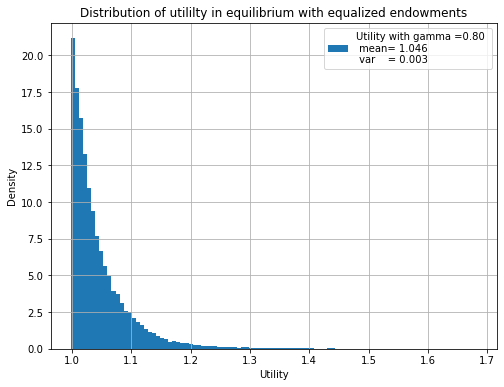

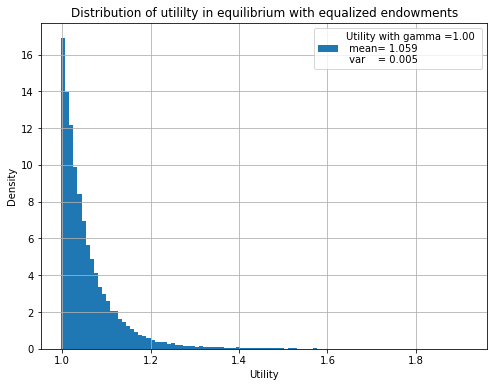

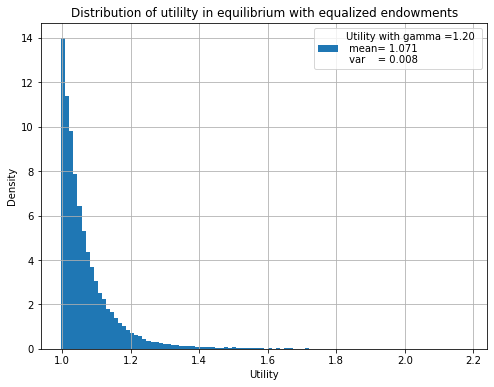

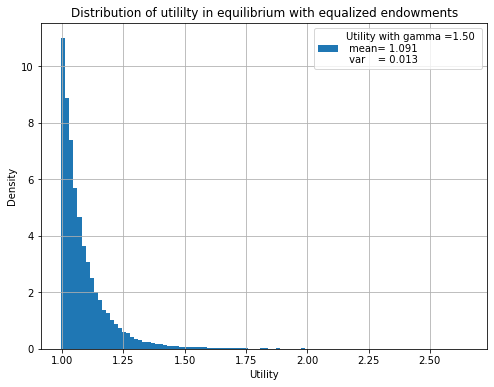

In [112]:
# Plot for different gammas:

for gamma in [0.5,0.8,1,1.2,1.5]:
    u_vec_equal = utility(xs_equal, betas,gamma)
    mean_equal, var_equal = np.mean(u_vec_equal), np.var(u_vec_equal)
    fig,ax = fun.plot_hist([u_vec_equal],names=[f'Utility with gamma ={gamma:1.2f} \n mean= {mean_equal:1.3f} \n var    = {var_equal:1.3f}'],
                       x_label=r'Utility',bins=100,alpha=1,
                       title='Distribution of utililty in equilibrium with equalized endowments')

In [113]:
# Plot mean and variance as a function of gamma:
gammas = np.linspace(0.5,2,100)
u_vec_equal_vec = [utility(xs_equal, betas,gamma) for gamma in gammas]
mean_equal_vec  = np.mean(u_vec_equal_vec,axis=1)
var_equal_vec  = np.var(u_vec_equal_vec,axis=1)

u_vec_vec = [utility(xs, betas,gamma) for gamma in gammas]
mean_vec  = np.mean(u_vec_vec,axis=1)
var_vec  = np.var(u_vec_vec,axis=1)

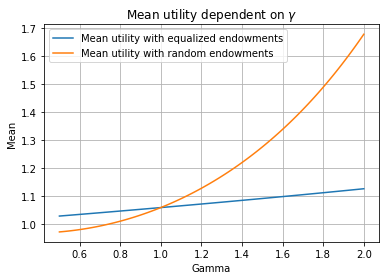

In [114]:
fig, ax = fun.plot('Gamma',['Mean utility with equalized endowments','Mean utility with random endowments'],
                   gammas,[mean_equal_vec,mean_vec],'Mean',
                   title=r'Mean utility dependent on $\gamma$',figsize=(6,4))

When $\gamma<1$ the mean is increased when switching to equalized endowments <br>
When $\gamma=1$ the mean is unaffected when switching to equalized endownments <br>
When $\gamma>1$ the mean is decreased when switching to equalized endowments

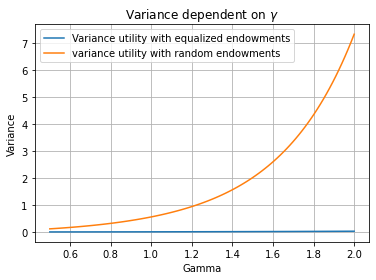

In [115]:
fig, ax = fun.plot('Gamma',['Variance utility with equalized endowments','variance utility with random endowments'],
                   gammas,[var_equal_vec,var_vec],'Variance',
                   title=r'Variance dependent on $\gamma$',figsize=(6,4))

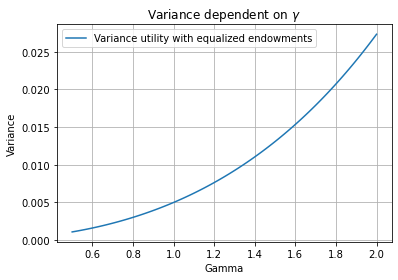

In [116]:
fig, ax = fun.plot('Gamma',['Variance utility with equalized endowments'],
                   gammas,[var_equal_vec],'Variance',
                   title=r'Variance dependent on $\gamma$',figsize=(6,4))